In [31]:
import json
import multiprocessing
import tempfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from gimpformats.gimpXcfDocument import GimpDocument
from PIL import Image
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map

In [2]:
# load dataset
response = requests.get(
    "https://api.figshare.com/v2/collections/6984822/articles?page_size=240"
)
data = response.json()
data[0], len(data)

({'id': 25807111,
  'title': 'Subject 74 co-registered scan 2',
  'doi': '10.6084/m9.figshare.25807111.v1',
  'handle': '',
  'url': 'https://api.figshare.com/v2/articles/25807111',
  'published_date': '2024-08-23T10:04:51Z',
  'thumb': 'https://s3-eu-west-1.amazonaws.com/ppreviews-npg-489897889/46283905/thumb.png',
  'defined_type': 3,
  'defined_type_name': 'dataset',
  'group_id': 2826,
  'url_private_api': 'https://api.figshare.com/v2/account/articles/25807111',
  'url_public_api': 'https://api.figshare.com/v2/articles/25807111',
  'url_private_html': 'https://figshare.com/account/articles/25807111',
  'url_public_html': 'https://springernature.figshare.com/articles/dataset/Subject_74_co-registered_scan_2/25807111',
  'timeline': {'posted': '2024-08-23T10:04:51',
   'firstOnline': '2024-08-23T10:04:51'},
  'resource_title': None,
  'resource_doi': None},
 213)

In [3]:
# load samples metadata
json_data = list(
    tqdm(
        thread_map(
            lambda x: json.loads(requests.get(x["url"]).text),
            data,
            max_workers=multiprocessing.cpu_count(),
        )
    )
)
json_data[0]

100%|██████████| 213/213 [00:00<00:00, 1372329.88it/s]


{'files': [{'id': 46283905,
   'name': '74.1_registered.jpeg',
   'size': 42749,
   'is_link_only': False,
   'download_url': 'https://ndownloader.figshare.com/files/46283905',
   'supplied_md5': 'a4d5b08b8c5c95cef42c4ed4249fbc5c',
   'computed_md5': 'a4d5b08b8c5c95cef42c4ed4249fbc5c',
   'mimetype': 'image/jpeg'}],
 'custom_fields': [{'name': 'Research Data Support', 'value': ''}],
 'authors': [{'id': 13918917,
   'full_name': 'Mariano Cabezas',
   'first_name': 'Mariano',
   'last_name': 'Cabezas',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659023,
   'full_name': 'Yago Diez',
   'first_name': 'Yago',
   'last_name': 'Diez',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659026,
   'full_name': 'Clara Martinez-Diago',
   'first_name': 'Clara',
   'last_name': 'Martinez-Diago',
   'is_active': False,
   'url_name': '_',
   'orcid_id': ''},
  {'id': 17659029,
   'full_name': 'Anna Maroto',
   'first_name': 'Anna',
   'last_name'

In [4]:
# get unique samples
urls = [
    sample["files"][0]["download_url"]
    for sample in json_data
    if sample["files"][0]["mimetype"] == "image/x-xcf"
]
n_unique = len(urls)
n_unique

104

In [5]:
# helper fns
def clean_ux(image):
    """
    Function designed to clean the UX from a US image from Girona.

    :param image: Image with the UX.
    :return: a clean image without UX.
    """
    new_image = image.copy()
    new_image[:50, ...] = 0
    new_image[:150, -100:] = 0
    new_image[:, :40] = 0

    return new_image


def get_points(image):
    """
    Function designed to take an image with manually drawn points and return
    the set of coordinates for their centroid.

    :param image: RGB image with the point annotations.
    :return:  numpy aray with the centroids (points x coordinates).
    """
    # We us OpenCV to binarize the image and detect the points.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray[gray > 0] = 255

    # We use OpenCV to compute the centroids of the annotated points.
    _, _, _, centroids = cv2.connectedComponentsWithStats(gray)

    # We ignore the background centroid (first and largest one).
    return centroids[1:]


def makeDict(names, points):
    """
    Given two lists of layers and another list with the lists of points in each layer at every position,
    create a dictionary with layer names as keys
    and the lists of points as values
    """
    return {names[i]: points[i] for i in range(len(names))}


def load_xcf(path):
    """
    Given the name of a xcf file, this functions reads it using GimpDocument,
    extract a list of images along with a list of layer names and returns them
    as two lists.
    :param path: Path to the image.
    :return: list of the layer names and their data (images).
    """

    # List data on groups followed by the direct children of a gimp xcf
    # document.
    project = GimpDocument(path)
    layers = project.layers
    # CAUTION: We are including the image. It's important if we only want the
    # coordinates of the annotatons, as we will need to ignore it!
    names, data = zip(
        *[(layer.name, layer.image) for layer in layers if not layer.isGroup]
    )
    labels = list(names)[:-1]
    annotations = list(data)[:-1]
    points = [get_points(np.array(x)) for x in annotations]
    image = clean_ux(np.array(data[-1])[..., 0])

    return image, labels, points


100%|██████████| 104/104 [00:00<00:00, 697932.19it/s]


{'calota': array([[545., 182.],
       [239., 273.],
       [652., 378.],
       [506., 490.]]), 'talems': array([[414., 275.],
       [372., 304.],
       [393., 351.]]), 'cerebel': array([[345., 213.],
       [298., 247.],
       [375., 269.],
       [297., 284.],
       [364., 302.],
       [275., 314.],
       [359., 332.],
       [303., 358.]]), 'cavum': array([[550., 328.],
       [517., 330.],
       [514., 357.],
       [550., 364.]]), 'silvio': array([[440., 441.],
       [514., 470.],
       [415., 472.]]), 'astes anteriors': array([[586., 308.],
       [573., 401.]]), 'linia mitja': array([[552., 356.],
       [606., 366.]])}


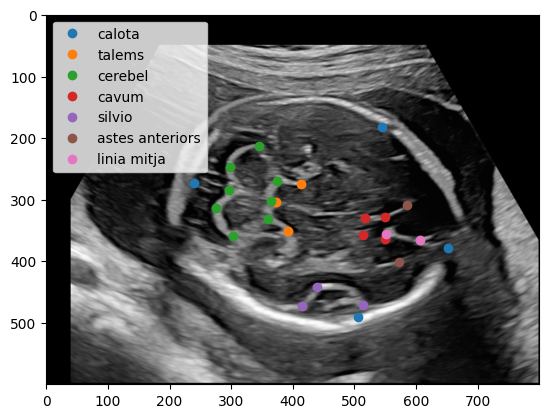

In [6]:
# collect metadata and images
def process_xcf(url: str, i: int):
    xcf_data = requests.get(url).content
    tmp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".xcf").name
    with open(tmp_file, "wb") as f:
        f.write(xcf_data)
    image, labels, points = load_xcf(tmp_file)
    names_to_points = makeDict(labels, points)
    pil_image = Image.fromarray(image)
    return names_to_points, pil_image


xcfs = list(
    tqdm(
        thread_map(
            process_xcf,
            urls,
            range(n_unique),
            max_workers=multiprocessing.cpu_count(),
        )
    )
)

print(xcfs[0][0])  # names_to_points
plt.imshow(np.array(xcfs[0][1].convert("RGB")))
for label, points in xcfs[0][0].items():
    plt.plot(points[:, 0], points[:, 1], "o", label=label)
plt.legend()
plt.show()

In [7]:
# separate metadata and images
flattened = [all for xcf in xcfs for all in xcf]
names_to_points = [item for idx, item in enumerate(flattened) if idx % 2 == 0]
images = [item for idx, item in enumerate(flattened) if idx % 2 == 1]
print(names_to_points[0], images[0])

{'calota': array([[545., 182.],
       [239., 273.],
       [652., 378.],
       [506., 490.]]), 'talems': array([[414., 275.],
       [372., 304.],
       [393., 351.]]), 'cerebel': array([[345., 213.],
       [298., 247.],
       [375., 269.],
       [297., 284.],
       [364., 302.],
       [275., 314.],
       [359., 332.],
       [303., 358.]]), 'cavum': array([[550., 328.],
       [517., 330.],
       [514., 357.],
       [550., 364.]]), 'silvio': array([[440., 441.],
       [514., 470.],
       [415., 472.]]), 'astes anteriors': array([[586., 308.],
       [573., 401.]]), 'linia mitja': array([[552., 356.],
       [606., 366.]])} <PIL.Image.Image image mode=L size=800x600 at 0x7C6AC8208F20>


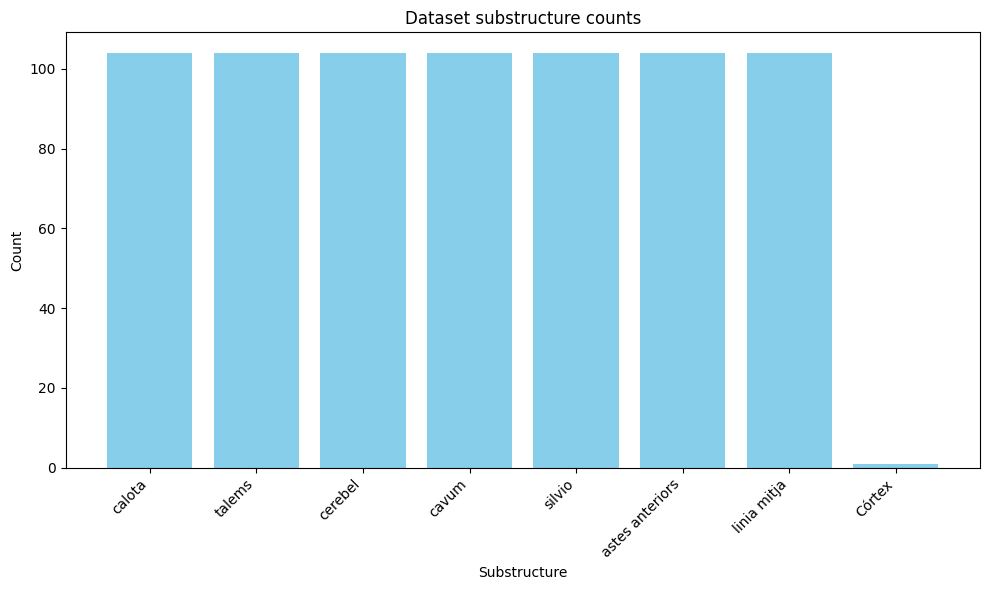

In [23]:
# get cts of each substructure
sub_cts = {}
for sample in names_to_points:
    for name in sample.keys():
        sub_cts[name] = sub_cts.get(name, 0) + 1
sub_names = list(sub_cts.keys())

plt.figure(figsize=(10, 6))
plt.bar(sub_names, list(sub_cts.values()), color="skyblue")
plt.xlabel("Substructure")
plt.ylabel("Count")
plt.title("Dataset substructure counts")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
# dimensions of images
min_w = min(img.width for img in images)
min_h = min(img.height for img in images)
max_w = max(img.width for img in images)
max_h = max(img.height for img in images)
min_w, min_h, max_w, max_h

(800, 600, 800, 600)

calota, min=4, max=6, mean=4.03, std=0.22
talems, min=3, max=4, mean=3.07, std=0.25
cerebel, min=6, max=8, mean=7.97, std=0.22
cavum, min=4, max=5, mean=4.01, std=0.10
silvio, min=3, max=3, mean=3.00, std=0.00
astes anteriors, min=0, max=2, mean=1.98, std=0.20
linia mitja, min=2, max=2, mean=2.00, std=0.00
Córtex, min=2, max=2, mean=2.00, std=0.00


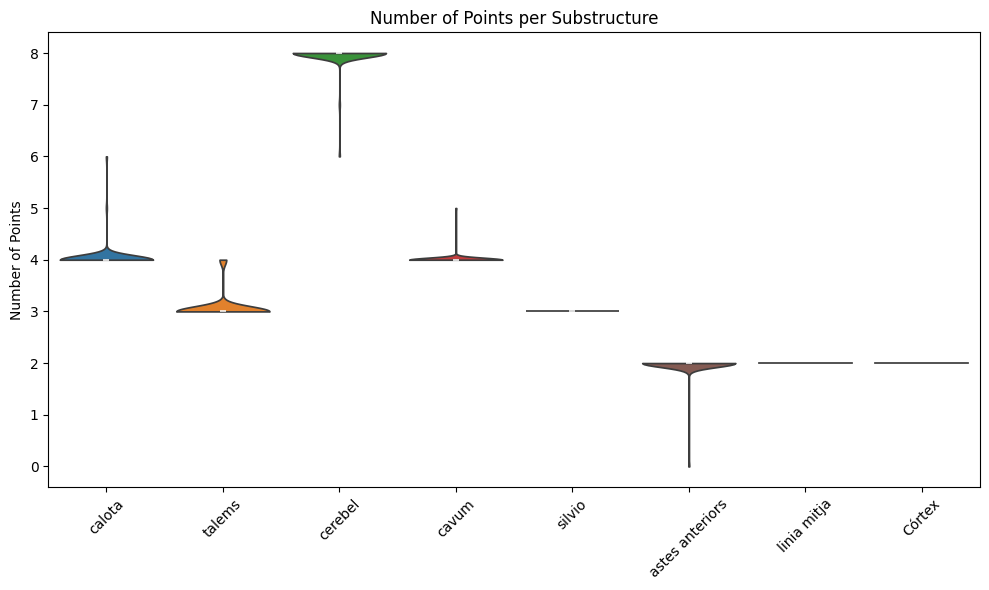

In [24]:
# dist of number of pts
pt_cts = {}
for name in sub_names:
    pts = [ntp[name] for ntp in names_to_points if name in ntp]
    n_pts = [len(pt) for pt in pts]
    pt_cts[name] = n_pts
    print(
        f"{name}, min={min(n_pts)}, max={max(n_pts)}, mean={np.mean(n_pts):.2f}, std={np.std(n_pts):.2f}"
    )
data = [pt_cts[name] for name in sub_names]

plt.figure(figsize=(10, 6))
sns.violinplot(data=data, cut=0, inner="box")
plt.xticks(ticks=range(len(sub_names)), labels=sub_names, rotation=45)
plt.title("Number of Points per Substructure")
plt.ylabel("Number of Points")
plt.tight_layout()
plt.show()


calota, x_min=76.0, x_max=684.0, x_mean=394.76, x_std=144.08, y_min=76.0, y_max=684.0, y_mean=394.76, y_std=144.08
talems, x_min=260.0, x_max=541.0, x_mean=406.54, x_std=64.70, y_min=260.0, y_max=541.0, y_mean=406.54, y_std=64.70
cerebel, x_min=166.0, x_max=637.0, x_mean=416.76, x_std=120.27, y_min=166.0, y_max=637.0, y_mean=416.76, y_std=120.27
cavum, x_min=236.0, x_max=586.0, x_mean=387.01, x_std=79.07, y_min=236.0, y_max=586.0, y_mean=387.01, y_std=79.07
silvio, x_min=250.0, x_max=561.0, x_mean=395.61, x_std=56.00, y_min=250.0, y_max=561.0, y_mean=395.61, y_std=56.00
astes anteriors, x_min=181.0, x_max=618.0, x_mean=377.39, x_std=123.64, y_min=181.0, y_max=618.0, y_mean=377.39, y_std=123.64
linia mitja, x_min=137.0, x_max=623.0, x_mean=377.08, x_std=128.76, y_min=137.0, y_max=623.0, y_mean=377.08, y_std=128.76
Córtex, x_min=273.0, x_max=303.0, x_mean=288.00, x_std=15.00, y_min=273.0, y_max=303.0, y_mean=288.00, y_std=15.00


/tmp/ipykernel_3636791/2285250061.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(sub_names, rotation=45)
/tmp/ipykernel_3636791/2285250061.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(sub_names, rotation=45)


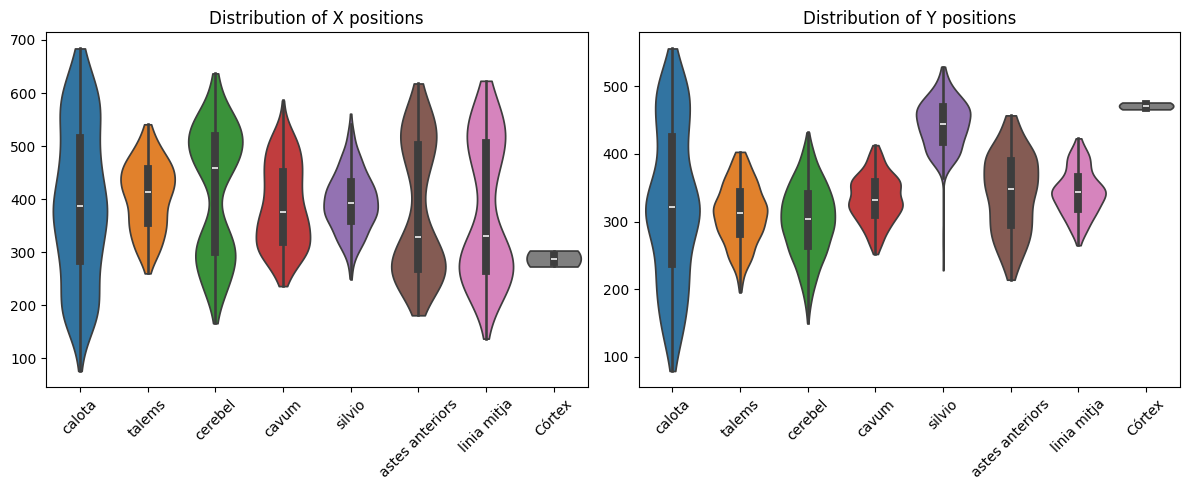

In [27]:
# dist of x,y pos
ntpos = {}
for name in sub_names:
    pts = [ntp[name] for ntp in names_to_points if name in ntp]
    x_pos = [pos[0] for pt in pts for pos in pt]
    y_pos = [pos[1] for pt in pts for pos in pt]
    ntpos[name] = (x_pos, y_pos)
    print(
        f"{name}, x_min={min(x_pos)}, x_max={max(x_pos)}, x_mean={np.mean(x_pos):.2f}, x_std={np.std(x_pos):.2f}, y_min={min(x_pos)}, y_max={max(x_pos)}, y_mean={np.mean(x_pos):.2f}, y_std={np.std(x_pos):.2f}"
    )

x_data = [ntpos[name][0] for name in sub_names]
y_data = [ntpos[name][1] for name in sub_names]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(data=x_data, cut=0, inner="box", ax=axes[0])
axes[0].set_title("Distribution of X positions")
axes[0].set_xticklabels(sub_names, rotation=45)

sns.violinplot(data=y_data, cut=0, inner="box", ax=axes[1])
axes[1].set_title("Distribution of Y positions")
axes[1].set_xticklabels(sub_names, rotation=45)

plt.tight_layout()
plt.show()


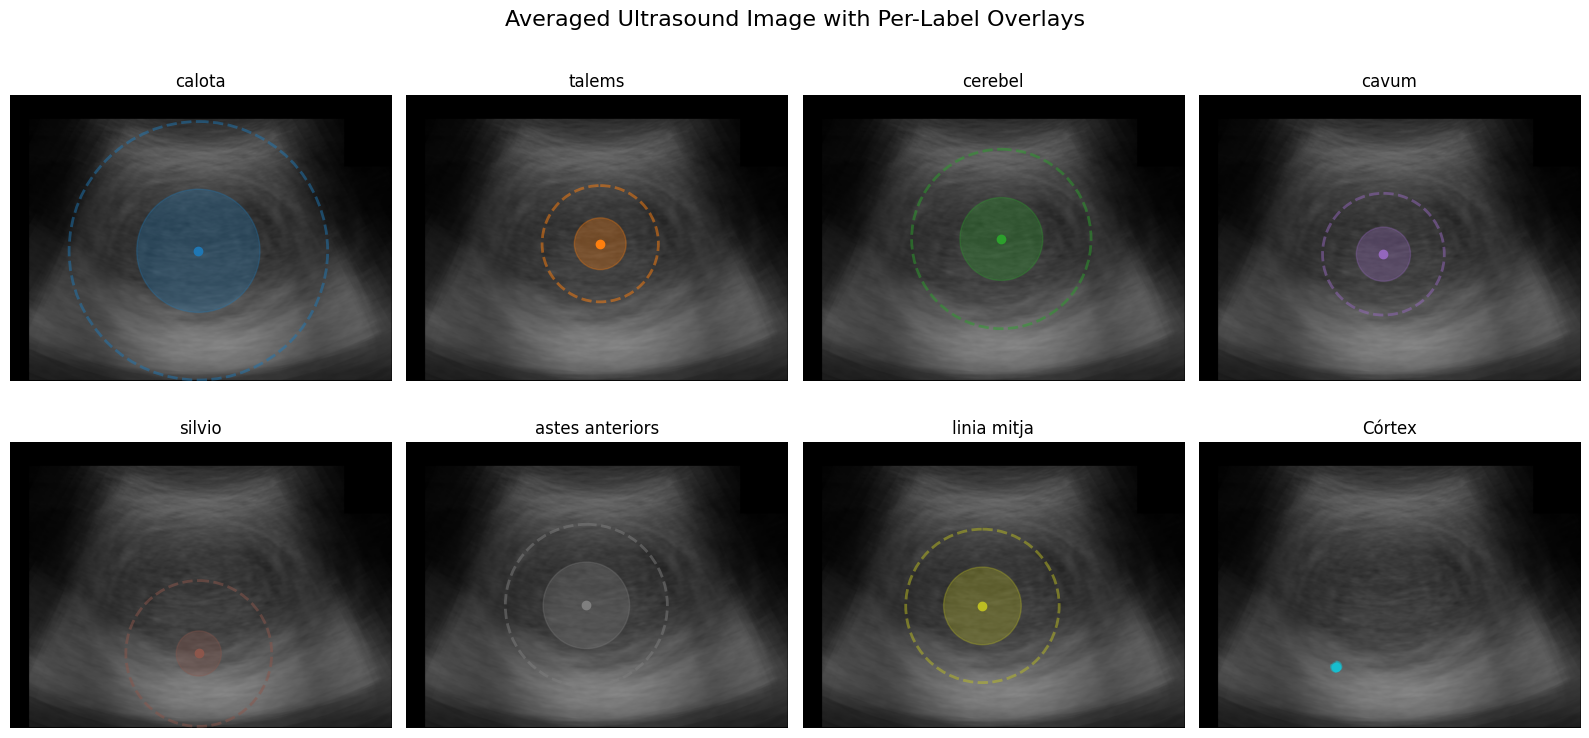

In [34]:
np_imgs = [np.array(img) for img in images]
stacked = np.stack(np_imgs, axis=0)
avg_img = stacked.mean(axis=0)
avg_img_pil = Image.fromarray(np.uint8(avg_img)).convert("RGB")

# Set up a grid of subplots
n_labels = len(sub_names)
ncols = 4
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()  # Flatten in case we have more than one row
fig.suptitle("Averaged Ultrasound Image with Per-Label Overlays", fontsize=16)
colors = plt.cm.tab10(np.linspace(0, 1, len(sub_names)))

for i, name in enumerate(sub_names):
    ax = axes[i]
    ax.imshow(avg_img_pil)

    x_pos, y_pos = ntpos[name]
    centroid = (np.mean(x_pos), np.mean(y_pos))
    std_radius = np.mean([np.std(x_pos), np.std(y_pos)])
    range_radius = np.mean([max(x_pos) - min(x_pos), max(y_pos) - min(y_pos)]) / 2

    color = colors[i]
    ax.plot(centroid[0], centroid[1], "o", color=color, markersize=6, zorder=3)
    ax.add_patch(
        Circle(
            centroid,
            range_radius,
            edgecolor=color,
            facecolor="none",
            lw=2,
            linestyle="--",
            alpha=0.5,
            zorder=1,
        )
    )
    ax.add_patch(Circle(centroid, std_radius, color=color, alpha=0.3, zorder=2))
    ax.set_title(name)
    ax.axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()